<a href="https://colab.research.google.com/github/DanielAlonsoCuriel/deeplearning/blob/main/AA_PRACTICA2_GRUPO_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AA_PRACTICA2_GRUPO_4

Daniel Alonso

Javier Arteaga

Marina Garrido

Elena González

### Importar librerías

In [26]:
%tensorflow_version 2.x
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
print(tensorflow.keras.__version__)
print('GPU Available:', tensorflow.config.list_physical_devices('GPU'))
print(tensorflow.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.2


In [27]:
from keras.datasets import fashion_mnist 
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras.layers.core import Flatten
from keras import metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

## Cargar los datos

Cargar los datos de Fashion MNIST en Keras. 

Hay 60K imágenes para entrenar la red y 10K para evaluar la precisión de clasificación.


In [28]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('Imágenes de entrenamiento:', train_images.shape)
print('Imágenes de test:', test_images.shape)

Imágenes de entrenamiento: (60000, 28, 28)
Imágenes de test: (10000, 28, 28)


Los datos tienen forma de 60K y 10K matrices (imágenes), respectivamente, de 28 filas x 28 columnas = 784 (píxeles).

Se modifica la forma de los datos a 60K y 10K matrices, respectivamente, de matrices 28x28. Además, se normalizan los datos para facilitar que converja el entrenamiento, ya que el resultado se obtiene en porcentaje de probabilidad (valores entre 0 y 1).

In [29]:
train_images.shape == (60000, 28, 28, 1)  # Forma tensor juego imagenes de entrenamiento
test_images.shape == (10000, 28, 28, 1)  # Forma tensor juego imagenes de test
train_labels.shape == (60000,1)  # Forma tensor etiquetas de entrenamiento
test_labels.shape == (10000,1)  # Forma tensor etiquetas de test

False

ddd

In [30]:
train_data = train_images.reshape((60000, 28 , 28, 1))
train_data = train_images.astype('float32') / 255
test_data = test_images.reshape((10000, 28 , 28, 1))
test_data = test_images.astype('float32') / 255
print('Imágenes de entrenamiento:', train_data.shape)
print('Imágenes de test:', test_data.shape)

Imágenes de entrenamiento: (60000, 28, 28)
Imágenes de test: (10000, 28, 28)


Se codifican las etiquetas de las imágenes de forma que lo pueda procesar la red. Cada etiqueta se convierte en un vector de 10 elementos (número de categorías) en el que el único valor distinto de ```0``` es un ```1``` en la posición de la categoría a la que corresponde.

In [31]:
#NO HACER
#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)

Se seleccionan 10K imágenes de entrenamiento como datos de validación para poder estudiar la precisión de la red frente a nuevos datos.

In [32]:
# Datos de validación
val_images = train_images[:10000]
val_labels = train_labels[:10000]

# Datos de entrenamiento
train_val_images = train_images[10000:]
train_val_labels = train_labels[10000:]


## Caso 1

### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```relu```, y una capa de salida con función de activación ```softmax```.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

dd

In [40]:
# Configuración del modelo 1
batch_size = 50
img_width, img_height, img_num_channels = 28,28,1 # Forma de la imagen
loss_function = sparse_categorical_crossentropy
no_epochs = 5
optimizer = 'sgd'
validation_split = 0.2
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [41]:
model = models.Sequential()
model.add(Conv2D(32, (5, 5), strides=(1,1), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), strides=(1,1), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [42]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)               

Se definen las funciones del optimizador, la pérdida y la métrica.

In [43]:
model.compile(optimizer = optimizer,
              loss = loss_function,
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [47]:
history = model.fit(train_val_images, train_val_labels,
                    batch_size = batch_size,
                    epochs = no_epochs,
                    verbose= verbosity,
                    validation_data=(val_images, val_labels))

Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6120 - accuracy: 0.7681 - val_loss: 0.5880 - val_accuracy: 0.7779
Epoch 2/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5760 - accuracy: 0.7818 - val_loss: 0.5507 - val_accuracy: 0.7931
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5439 - accuracy: 0.7940 - val_loss: 0.5393 - val_accuracy: 0.7873
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5243 - accuracy: 0.8047 - val_loss: 0.5177 - val_accuracy: 0.8078
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5016 - accuracy: 0.8125 - val_loss: 0.5218 - val_accuracy: 0.8085


La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [48]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.5454 - accuracy: 0.8035
Test accuracy: 0.5454426407814026
Test accuracy: 0.8034999966621399


dd

Test loss: 0.49864527583122253 / Test accuracy: 0.8163166642189026


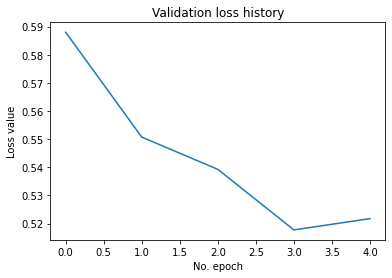

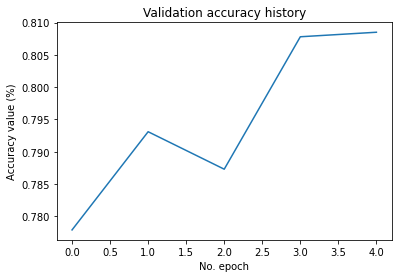

In [49]:
# Generamos las métricas de generalización
score = model.evaluate(train_images, train_labels, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualizamos history
# Pintamos history: Pérdida
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Pintamos history: Precisión
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

dd

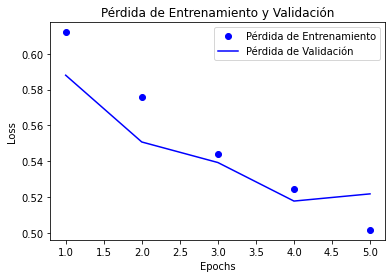

In [50]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [51]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [54]:
Y_pred = model.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

313/313 [==============================] - 1s 2ms/step
Valores de predicción del modelo


AxisError: ignored

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

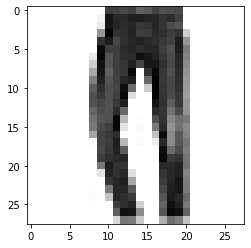

1


In [55]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [56]:
predictions = model.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

313/313 [==============================] - 1s 2ms/step
Predicción del elemento 6: clase 5
[1.09931585e-04 2.87703844e-03 6.84833601e-02 1.67338580e-01
 1.59119384e-08 6.43018365e-01 7.25933933e-06 1.01101235e-03
 1.17153220e-01 1.21270625e-06]
Suma de las predicciones del elemento 6: 0.99999994


In [57]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')



s

NameError: ignored

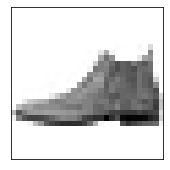

In [58]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

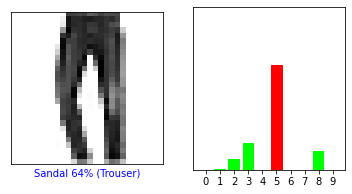

In [59]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plot_image(5, predictions[5], test_labels, test_images.reshape(10000,28,28))
plt.subplot(1,2,2)
plot_value_array(5, predictions[5],  test_labels)
plt.show()

## Caso 1.5


### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```relu```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model1b = models.Sequential()
model1b.add(Conv2D(64, (7, 7), strides=(1,1), activation='tanh', input_shape=(28, 28, 2)))
model1b.add(MaxPooling2D((2, 2)))

model1b.add(Conv2D(128, (3, 3), strides=(1,1), activation='tanh', input_shape=(28, 28, 2)))
model1b.add(MaxPooling2D((2, 2)))

model1b.add(Flatten())
model1b.add(Dense(65,activation='relu'))
model1b.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [ ]:
model1b.summary()

Se definen las funciones del optimizador, la pérdida y la métrica.

In [ ]:
model1b.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model1b.fit(train_images, train_labels,
                    batch_size = 532,
                    epochs = 25,
                    verbose=1)

La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model1b.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model1b.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model1b.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

## Caso 2

In [ ]:
# Configuración del modelo 2
batch_size = 100
img_width, img_height, img_num_channels = 28,28,1 # Forma de la imagen
loss_function = sparse_categorical_crossentropy
no_epochs = 5
optimizer = 'sgd'
validation_split = 0.2
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```relu```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model2 = models.Sequential()
model2.add(Conv2D(64, (7, 7), strides=(1,1), activation='relu',padding = 'same', input_shape=(28, 28, 2)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3), strides=(1,1), activation='relu',padding = 'same', input_shape=(28, 28, 2)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
model2.add(Dense(65,activation='relu'))
model2.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [ ]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        6336      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 65)               

Se definen las funciones del optimizador, la pérdida y la métrica.

In [ ]:
model.compile(optimizer = optimizer,
              loss = loss_function,
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model.fit(train_val_images, train_val_labels,
                    batch_size = batch_size,
                    epochs = no_epochs,
                    verbose= verbosity,
                    validation_data=(val_images, val_labels))

Epoch 1/5
600/600 [==============================] - 2s 3ms/step - loss: 0.5920 - accuracy: 0.7776
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.5923 - accuracy: 0.7779
Epoch 3/5
600/600 [==============================] - 2s 3ms/step - loss: 0.5622 - accuracy: 0.7895
Epoch 4/5
600/600 [==============================] - 2s 3ms/step - loss: 0.5509 - accuracy: 0.7915
Epoch 5/5
600/600 [==============================] - 2s 3ms/step - loss: 0.5448 - accuracy: 0.7951


La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

NameError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: ignored

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model2.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model2.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

## Caso 2.5 (para pruebas)

### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```sigmoid```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model2b = models.Sequential()
model2b.add(Conv2D(64, (7, 7), strides=(1,1), activation='relu', input_shape=(28, 28, 2)))
model2b.add(MaxPooling2D((2, 2)))

model2b.add(Conv2D(128, (3, 3), strides=(1,1), activation='relu', input_shape=(28, 28, 2)))
model2b.add(MaxPooling2D((2, 2)))

model2b.add(Flatten())
model2b.add(Dense(65,activation='relu'))
model2b.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [ ]:
model2b.summary()

Se definen las funciones del optimizador, la pérdida y la métrica.

In [ ]:
model3b.compile(optimizer = 'sgd',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model3b.fit(train_images, train_labels,
                    batch_size = 532,
                    epochs = 5,
                    verbose=1)

La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model3b.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

## Caso 3

### Crear la red de neuronas

In [ ]:
# Configuración del modelo 3
batch_size = 532
img_width, img_height, img_num_channels = 28,28,1 # Forma de la imagen
loss_function = sparse_categorical_crossentropy
no_epochs = 5
optimizer = Adam()
validation_split = 0.2
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```sigmoid```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model3 = models.Sequential()
model3.add(Conv2D(64, (7, 7), strides=(1,1), activation='relu', padding='same', input_shape=(28, 28, 2)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same', input_shape=(28, 28, 2)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())
model3.add(Dense(65,activation='relu'))
model3.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [ ]:
model3.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        6336      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 6272)              0         
                                                                 
 dense_11 (Dense)            (None, 65)               

Se definen las funciones del optimizador, la pérdida y la métrica.

Probamos que pasaría si cambiamos el optimizador por 'adam' y la funcion de perdida por 'sparse_categorical_crossentropy'. El optimizador adam es una combinacion de AdaGrad y RMSProp ya que además de RMSProp, cada factor de entrenamiento también se ve afectado por el momentum del gradiente. (https://respuestasrapidas.com.mx/que-es-optimizador-adam/) La función de pérdida sparse_categorical_crossentropy, es una medida de distancia entre probabilidades al igual que categorical_crossentropy pero este caso es usado unicamente para numeros enteros.(https://ignaciogavilan.com/catalogo-de-componentes-de-redes-neuronales-iii-funciones-de-perdida/)

In [ ]:
model.compile(optimizer = optimizer,
              loss = loss_function,
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model.fit(train_val_images, train_val_labels,
                    batch_size = batch_size,
                    epochs = no_epochs,
                    verbose= verbosity,
                    validation_data=(val_images, val_labels))

Epoch 1/5
113/113 [==============================] - 2s 10ms/step - loss: 0.5118 - accuracy: 0.8066
Epoch 2/5
113/113 [==============================] - 1s 9ms/step - loss: 0.4897 - accuracy: 0.8143
Epoch 3/5
113/113 [==============================] - 1s 9ms/step - loss: 0.4696 - accuracy: 0.8230
Epoch 4/5
113/113 [==============================] - 1s 9ms/step - loss: 0.4489 - accuracy: 0.8311
Epoch 5/5
113/113 [==============================] - 1s 9ms/step - loss: 0.4319 - accuracy: 0.8378


La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('test_loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model3b.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model3b.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

## Caso 3.5 (para pruebas)

### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 10 neuronas y función de activación ```sigmoid```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model3b = models.Sequential()
model3b.add(Conv2D(64, (7, 7), strides=(1,1), activation='relu', input_shape=(28, 28, 2)))
model3b.add(MaxPooling2D((2, 2)))

model3b.add(Conv2D(128, (3, 3), strides=(1,1), activation='relu', input_shape=(28, 28, 2)))
model3b.add(MaxPooling2D((2, 2)))

model3b.add(Flatten())
model3b.add(Dense(65,activation='relu'))
model3b.add(Dense(10,activation='softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 7850 = 784 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

En el caso de la segunda capa: 110 = 10 (tamaño de los datos) x 10 (número de neuronas) + 10 (número de umbrales de activación).

In [ ]:
model3b.summary()

Se definen las funciones del optimizador, la pérdida y la métrica.

In [ ]:
model3b.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model3b.fit(train_images, train_labels,
                    batch_size = 532,
                    epochs = 5,
                    verbose=1)

La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model3b.evaluate(test_images, test_labels)
print('test_loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model3b.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model3b.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
for i in range(14):
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels)
  plt.show()

## Caso 8

### Crear la red de neuronas

Se crea la red neuronal con una capa de entrada con 512 neuronas y función de activación ```sigmoid```, y una capa de salida con función de activación ```softmax```.

In [ ]:
model8 = models.Sequential()
model8.add(layers.Dense(512, activation ='sigmoid', name = 'Capa8', input_shape = (28*28,)))
model8.add(layers.Dense(10, name = 'CapaSalida8', activation = 'softmax'))

### Explicar model.summary()


El resumen del modelo indica el número de parámetros de salida de cada capa. Este número es igual al tamaño de los datos de entrada multiplicado por el número de neuronas, y sumando el número de umbrales de activación de la capa.


En el caso de la primera capa: 401920 = 784 (tamaño de los datos) x 512 (número de neuronas) + 512 (número de umbrales de activación).

En el caso de la segunda capa: 262656 = 512 (tamaño de los datos) x 512 (número de neuronas) + 512 (número de umbrales de activación).

In [ ]:
model8.summary()

Se definen las funciones del optimizador, la pérdida y la métrica.

In [ ]:
model8.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Entrenar la red

Para entrenar la red se realizan ```5``` ciclos con lotes de ```128``` imágenes. Se compara con los datos de validación para controlar el sobreentrenamiento. 

In [ ]:
history = model8.fit(train_val_data, train_val_labels,
                    epochs = 5,
                    batch_size = 524,
                    validation_data = (val_data, val_labels))

Al aumentar el batch_size a 524 la precisión del modelo aumenta.

La pérdida indica el porcentaje de errores entre las etiquetas y las predicciones del modelo.

La precisión indica el porcentaje de aciertos entre las predicciones y las etiquetas.

In [ ]:
test_loss, test_acc = model8.evaluate(test_data, test_labels)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Predecir valores

Imprimir la matriz de confusión, que muestra los valores predichos frente a los reales.

In [ ]:
# Note, this code is taken straight from the SKLEARN website, an nice way of 
# viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize = True`.
    '''
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [ ]:
Y_pred = model8.predict(test_data)
print('Valores de predicción del modelo')
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Dibujar la matriz de confusión
print('Matriz de confusión')
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se grafica el elemento 6 (```test_data[5]```) para comprobar las soluciones. 

In [ ]:
digit = test_data.reshape(10000,28, 28)[5]
plt.imshow(digit, cmap = plt.cm.binary)
plt.show()
print(test_labels[5])

La clase del elemento 6 es la clase 1 (pantalones).

In [ ]:
predictions = model8.predict(test_data)
print('Predicción del elemento 6: clase', np.argmax(predictions[5]))
print(predictions[5])
print('Suma de las predicciones del elemento 6:', np.sum(predictions[5]))

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap = plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label.all() == true_label.all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color = color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color = '#00FF00')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

In [ ]:
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plot_image(5, predictions[5], test_labels, test_data.reshape(10000,28,28))
plt.subplot(1,2,2)
plot_value_array(5, predictions[5],  test_labels)
plt.show()

# Conclusiones


En la siguiente tabla observamos los distintos casos con su valor de pérdida y su precisión. 

> 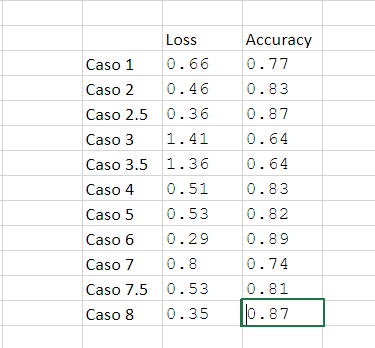



*   En los casos 1 y 2 ambos tienen capas de 10 neuronas y función de activación 
'relu' , lo que cambia es el optimizador. En el caso 1, el optimizador es el 'sgd' y observamos que tiene una precisión de 0.77 y el del caso 2, el 'rmsprop' con una precisión de 0.83. Por tanto podemos concluir que es más preciso el 'sgd'.
*   En los casos 3 y 4 ambos tienen capas de 10 neuronas y función de activación 'sigmoid' , lo que cambia es el optimizador. En el caso 3, el optimizador es el 'sgd' y observamos que tiene una precisión de 0.64 y el del caso 4, el 'rmsprop' con una precisión de 0.83. Por tanto podemos concluir que es más preciso el optimizador 'sgd'.
*  Comparando la función de activación'relu' y 'sigmoid' de los casos 1, 2, 3 y 4. La función de activación 'relu'(acc 0.77) tiene mayor precisión que 'sigmoid' (acc 0.64)


*   En los casos 5 y 6 ambos tienen capas de 512 neuronas y función de activación 'relu' , lo que cambia es el optimizador. En el caso 5, el optimizador es el 'sgd' y observamos que tiene una precisión de 0.82 y el del caso 6, el 'rmsprop' con una precisión 0.89. Por tanto podemos concluir que es más preciso el optimizador 'rmsprop'.
*   En los casos 7 y 8 ambos tienen capas de 512 neuronas y función de activación 'sigmoid' , lo que cambia es el optimizador. En el caso 7, el optimizador es el 'sgd' y observamos que tiene una precisión de 0.74 y el del caso 8, el 'rmsprop' con una precisión 0.81. Por tanto podemos concluir que es más preciso el optimizador 'rmsprop'.

*   Comparando la función de activación'relu' y 'sigmoid' de los casos 5, 6, 7 y 8. La función de activación 'relu' tiene mayor precisión que 'sigmoid'.

*  En los casos 2.5, 7.5 añadimos 25 épocas lo que nos lleva al sobreentrenamiento de nuestro modelo.

*   Por último, observamos que los modelos con 10 neuronas son menos precisas que los modelos con 512 neuronas.







